# Dead By Daylight Killer Tier List Predictive Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


# Read the Killer Data file into a DataFrame
df = pd.read_excel("KillerData.xlsx")
df.set_index('Name', inplace=True)
killer_data = df.copy()
killer_data

,Kill Rate,0 Kill Rate,1 Kill Rate,2 Kill Rate,3 Kill Rate,4 Kill Rate,Spd,Avg Max Spd,Avg Min Spd,Power Chase,Power Ctrl,Power Slow,Insta-Down,Skill Ceil,Skill Floor,Placement
Name,,,,,,,,,,,,,,,,
Trapper,53.67,21.17,18.18,14.85,16.41,29.39,4.60,4.60,0.000,Yes,Yes,No,Yes,Mid,Low,D
Wraith,57.47,20.49,15.97,11.88,16.48,35.18,4.60,7.00,1.600,Yes,Yes,No,No,High,Low,B
Hillbilly,57.72,17.63,17.17,14.68,17.71,32.81,4.60,9.20,1.380,Yes,Yes,No,Yes,Extreme,Mid,S
Nurse,55.64,22.10,15.99,11.50,18.07,32.34,3.85,6.16,0.960,Yes,Yes,No,No,Extreme,High,S
Shape,55.14,18.34,18.98,15.56,18.00,29.12,4.60,4.60,0.900,Yes,No,No,Yes,Mid,Low,D
Hag,56.45,21.65,15.86,11.91,16.17,34.41,4.40,999.00,0.000,Yes,Yes,No,No,High,Mid,B
Doctor,54.10,24.37,15.80,11.37,16.01,32.45,4.60,4.60,3.100,Yes,Yes,Yes,No,Mid,Mid,C
Huntress,52.59,21.56,19.06,14.51,17.21,27.66,4.40,40.00,3.080,Yes,No,No,No,Extreme,Mid,A
Cannibal,54.53,16.20,21.42,17.58,17.66,27.14,4.60,5.29,0.460,Yes,No,No,Yes,Mid,Low,C


## Data Overview

This dataset is comprised of the following data points:

- **Kill rate**: The percentage of survivors from the games that didn't escape.
- **0 Kill Rate**: Percentage of matches in which the killer was unable to get any kills. This is
the worst possible outcome for a killer.
- **1 Kill Rate**: Percentage of matches in which the killer got one kill. This usually happens
when the survivors manage to power the exit gates, but one survivor who was one hook
state away from death is captured, or when someone in general gets caught and the killer
patrols around the hook to guarantee at least one kill at the end of a match, because if
they go for someone else it will risk not getting any kills.
- **2 Kill Rate**: Percentage of matches in which the killer got 2 kills. Usually happens in
similar conditions to the 1 kill rate, but the killer managed to get one kill before the end
of the game. Usually the rarest outcome in a killer match, it is often considered a “tie”.
- **3 Kill Rate**: Percentage of matches in which the killer got 3 kills. Oftentimes considered a
victory, because if a killer gets 3 kills and there are a certain number of generators
powered, the survivor can escape through a hatch that appears in some area around the
map instead of having to power the remaining generators to open the exit gates.
Alternatively, the killer may close said hatch, which allows the survivor to try and open
the exit gates to escape. The 3 kill end also occurs when the killer decides to let the last
survivor escape, which happens extremely often in the game.
- **4 Kill Rate**: Percentage of matches in which the killer got 4 kills. Self explanatory,
translates to a killer victory. It may be a hard match in which the 4 kills got secured right
at the end, or the killer may have won overwhelmingly against the other team.
- **Movement Speed**: Average walking speed of the killer. What one gets by simply moving
forward without doing anything else. Most killers run at the same speed, but some move
distinctively slower because of the nature of their power.
- **Average Max Speed**: The top speed any one survivor will deal with often when facing
that killer. Because some killers have projectile powers, this stat considers the projectile
as an extension of the killer. Some killers can teleport around the map, and this is
considered as their maximum speed, with the 999m/s number being used to display that.
- **Average Min Speed**: The minimal speed any one survivor will deal with often when
facing that killer. Some killers will have movement speed penalties related to their
powers. When this movement speed often gets in the way of killers achieving their
objective, this is considered in the data.
- **Power Chase**: Indicates whether or not a killer’s power is generally useful to the killer
when chasing after the survivor. Because this tier list assumes good killers against good
survivors with no help, the data assumes that the killer knows how to use their power in
some creative ways, but it also assumes that survivors won’t make easily preventable
mistakes.
- **Power Control**: Indicates whether or not a killer’s power is generally useful to the killer
when applying pressure in the map. This usually means anything that allows the killer to
traverse the map rapidly, or to hinder survivors at a distance.
- **Power Slow**: Indicates whether or not a killer’s power is generally useful to the killer in
either slowing down generator progress, or keeping survivors away from generators, or
forcing them to do other tasks in the map that are not generators, slowing down their
progress towards powering the exit gates.
- **Insta-down**: Indicates whether or not the killer’s power can instantly take survivors from
the healthy state to the downed state, without going through the injured state. Note that
some killer add ons can do this, but this tier list assumes no outside influence.
- **Skill Ceiling**: Metric that represents what is the maximum possible ability one can
achieve with the killer, how good can one person possibly get to the point that there is no
easily spotted mistake that happened because of a lapse in skill. With some killers, there
is only so much you can do before you are restricted by general game mechanics, but
with others, the skill ceiling is so high it is hard to even find someone who reached it, if
anyone like that exists.
- **Skill Floor**: Metric that represents how easy it is to understand the basic concepts of the
killer, and to perform generally well while using the killer’s power to a decent extent.
- **Placement**: Where a killer would be placed in a tier list (average). This is the metric that
will be predicted by the model using the training data set. The existing placements were,
again, based on research and aggregation of multiple opinions, and are by no means the
“correct” placement, because tier lists often involve some subjective feelings, as well as
some objective ones.

### Analysis Summary
- **Key Findings**: 
  - High information gain observed for Skill Ceiling and Average Max Speed.
  - Features like Power Chase did not correlate as expected, because it appears that every killer released so far comes equipped with a way to use their power in a chase.
### Model Training and Selection
  - I've decided to train many models in this project to figure out which one works best. This includes using Logistic Regression, Decision Tree, Decision Tree with Entropy, Random Forest, SVC and Gradient Boosting.
  - Due to the lack of data, the dataset is quite sparse. This influences the accuracy of the predictions quite a lot, and it hardly ever makes an accurate prediction more than 50% of the time. However, there are 5 possible results, so a 50% accuracy here is much better than if this was a binary classifier, which would tie with a random guess.

### Perform data preprocessing

In [2]:
# Convert categorical text columns to 'category' data type
categorical_columns = ['Skill Ceil', 'Skill Floor', 'Placement']
for col in categorical_columns:
    killer_data[col] = killer_data[col].astype('category')

In [3]:
# Encode ordered categories for 'Skill Ceil' and 'Skill Floor' to avoid manual mappings
from pandas.api.types import CategoricalDtype
skill_order = CategoricalDtype(categories=["Low", "Mid", "High", "Extreme"], ordered=True)
killer_data['Skill Ceil'] = killer_data['Skill Ceil'].astype(skill_order)
killer_data['Skill Floor'] = killer_data['Skill Floor'].astype(skill_order)

In [4]:
# Function for binning Kill Rates based on column average
def bin_column_based_on_average(df, column):
    avg = df[column].mean()
    bins = [0, avg - 1, avg + 1, df[column].max()]
    labels = ['Low', 'Mid', 'High']
    return pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)

# Apply binning to each Kill Rate column
kill_rate_columns = ['Kill Rate', '0 Kill Rate', '1 Kill Rate', '2 Kill Rate', '3 Kill Rate', '4 Kill Rate']

for col in kill_rate_columns:
    killer_data[col] = pd.to_numeric(killer_data[col])
    killer_data[col] = bin_column_based_on_average(killer_data, col)

In [5]:
# Function for binning Avg Min Spd and Avg Max Spd columns based on quartiles
def bin_speed_column(df, column):
    q1, q2, q3 = df[column].quantile([0.25, 0.5, 0.75])
    bins = [0, q1, q2, q3, df[column].max()]
    labels = ['Low', 'Mid', 'High', 'Extreme']
    return pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)

# Apply binning to Avg Min Spd and Avg Max Spd columns
speed_columns = ['Avg Min Spd', 'Avg Max Spd']
for col in speed_columns:
    killer_data[col] = bin_speed_column(killer_data, col)

In [6]:
# Encode binary categorical columns ('Yes'/'No' as 1/0)
binary_columns = ['Power Chase', 'Power Ctrl', 'Power Slow', 'Insta-Down']
for col in binary_columns:
    killer_data[col] = killer_data[col].map({'Yes': 1, 'No': 0})

In [7]:
killer_data # New data

,Kill Rate,0 Kill Rate,1 Kill Rate,2 Kill Rate,3 Kill Rate,4 Kill Rate,Spd,Avg Max Spd,Avg Min Spd,Power Chase,Power Ctrl,Power Slow,Insta-Down,Skill Ceil,Skill Floor,Placement
Name,,,,,,,,,,,,,,,,
Trapper,Low,Mid,Mid,High,Low,Low,4.60,Low,Low,1,1,0,1,Mid,Low,D
Wraith,High,Mid,Low,Low,Low,High,4.60,Mid,Mid,1,1,0,0,High,Low,B
Hillbilly,High,Low,Mid,High,Mid,High,4.60,Mid,Mid,1,1,0,1,Extreme,Mid,S
Nurse,Mid,High,Low,Low,Mid,High,3.85,Mid,Mid,1,1,0,0,Extreme,High,S
Shape,Mid,Low,High,High,Mid,Low,4.60,Low,Low,1,0,0,1,Mid,Low,D
Hag,High,High,Low,Low,Low,High,4.40,Extreme,Low,1,1,0,0,High,Mid,B
Doctor,Low,High,Low,Low,Low,High,4.60,Low,High,1,1,1,0,Mid,Mid,C
Huntress,Low,High,High,High,Mid,Low,4.40,High,High,1,0,0,0,Extreme,Mid,A
Cannibal,Mid,Low,High,High,Mid,Low,4.60,Low,Low,1,0,0,1,Mid,Low,C


These changes are necessary to ensure that the uniqueness of data doesn't influence the entropy and information gain calculations. Binning the numbers into certain categories was necessary for the calculations that are about to come, as well as to train the model, since it can't work with labels that easily.

In [8]:
target_column = 'Placement'
features = killer_data.drop(columns=[target_column]).columns

## Feature Analysis Using Entropy and Information Gain

Entropy is a measure of uncertainty or impurity in the data. In the context of classification, entropy quantifies how mixed the target labels are within a feature's values. A feature that perfectly splits the data will have low entropy, while a feature that results in mixed labels will have high entropy.

Information Gain is the reduction in entropy after splitting the data based on a particular feature. It helps to identify which features provide the most information about the target variable. By calculating the information gain for each feature, we can prioritize those features that contribute most to the predictive power of the model.


In [9]:
# Functions that analyze entropy and information gain of a given column in the dataset

def entropy(column):
    value_counts = column.value_counts(normalize=True)
    return -np.sum(value_counts * np.log2(value_counts + 1e-10))

def information_gain(data, target_column, feature_column):
    # Calculate total entropy
    total_entropy = entropy(data[target_column])
    
    # Calculate the weighted average entropy of the feature
    feature_values = data[feature_column].unique()
    weighted_entropy = 0
    
    for value in feature_values:
        subset = data[data[feature_column] == value]
        weighted_entropy += (len(subset) / len(data)) * entropy(subset[target_column])
    
    return total_entropy - weighted_entropy

In [10]:
info_gains = {}
for feature in features:
    info_gains[feature] = information_gain(killer_data, target_column, feature)

# Sort features by information gain
sorted_features = sorted(info_gains.items(), key=lambda x: x[1], reverse=True)

# Print the sorted features
for feature, gain in sorted_features:
    print(f"Feature: {feature}, Information Gain: {gain}")

# Select the best feature (with the highest information gain)
best_feature = sorted_features[0][0]
print(f"Best feature for prediction: {best_feature}")

Feature: Skill Ceil, Information Gain: 0.7965623325689324
Feature: Avg Max Spd, Information Gain: 0.6564940906086303
Feature: Avg Min Spd, Information Gain: 0.4633102450309563
Feature: Skill Floor, Information Gain: 0.3779272982340707
Feature: 4 Kill Rate, Information Gain: 0.33921807033263884
Feature: 3 Kill Rate, Information Gain: 0.2869671766113717
Feature: Kill Rate, Information Gain: 0.2685582119792975
Feature: 1 Kill Rate, Information Gain: 0.2361034445383119
Feature: 2 Kill Rate, Information Gain: 0.2257432285604788
Feature: Insta-Down, Information Gain: 0.19849457889064692
Feature: Spd, Information Gain: 0.1573656736364799
Feature: 0 Kill Rate, Information Gain: 0.13696007963628531
Feature: Power Slow, Information Gain: 0.11860799522370824
Feature: Power Ctrl, Information Gain: 0.11809156985330604
Feature: Power Chase, Information Gain: 0.0
Best feature for prediction: Skill Ceil


In [11]:
temp_data = killer_data.copy()

for col in temp_data.drop(columns=['Placement']).select_dtypes(include=['category']).columns:
    temp_data[col] = temp_data[col].cat.codes

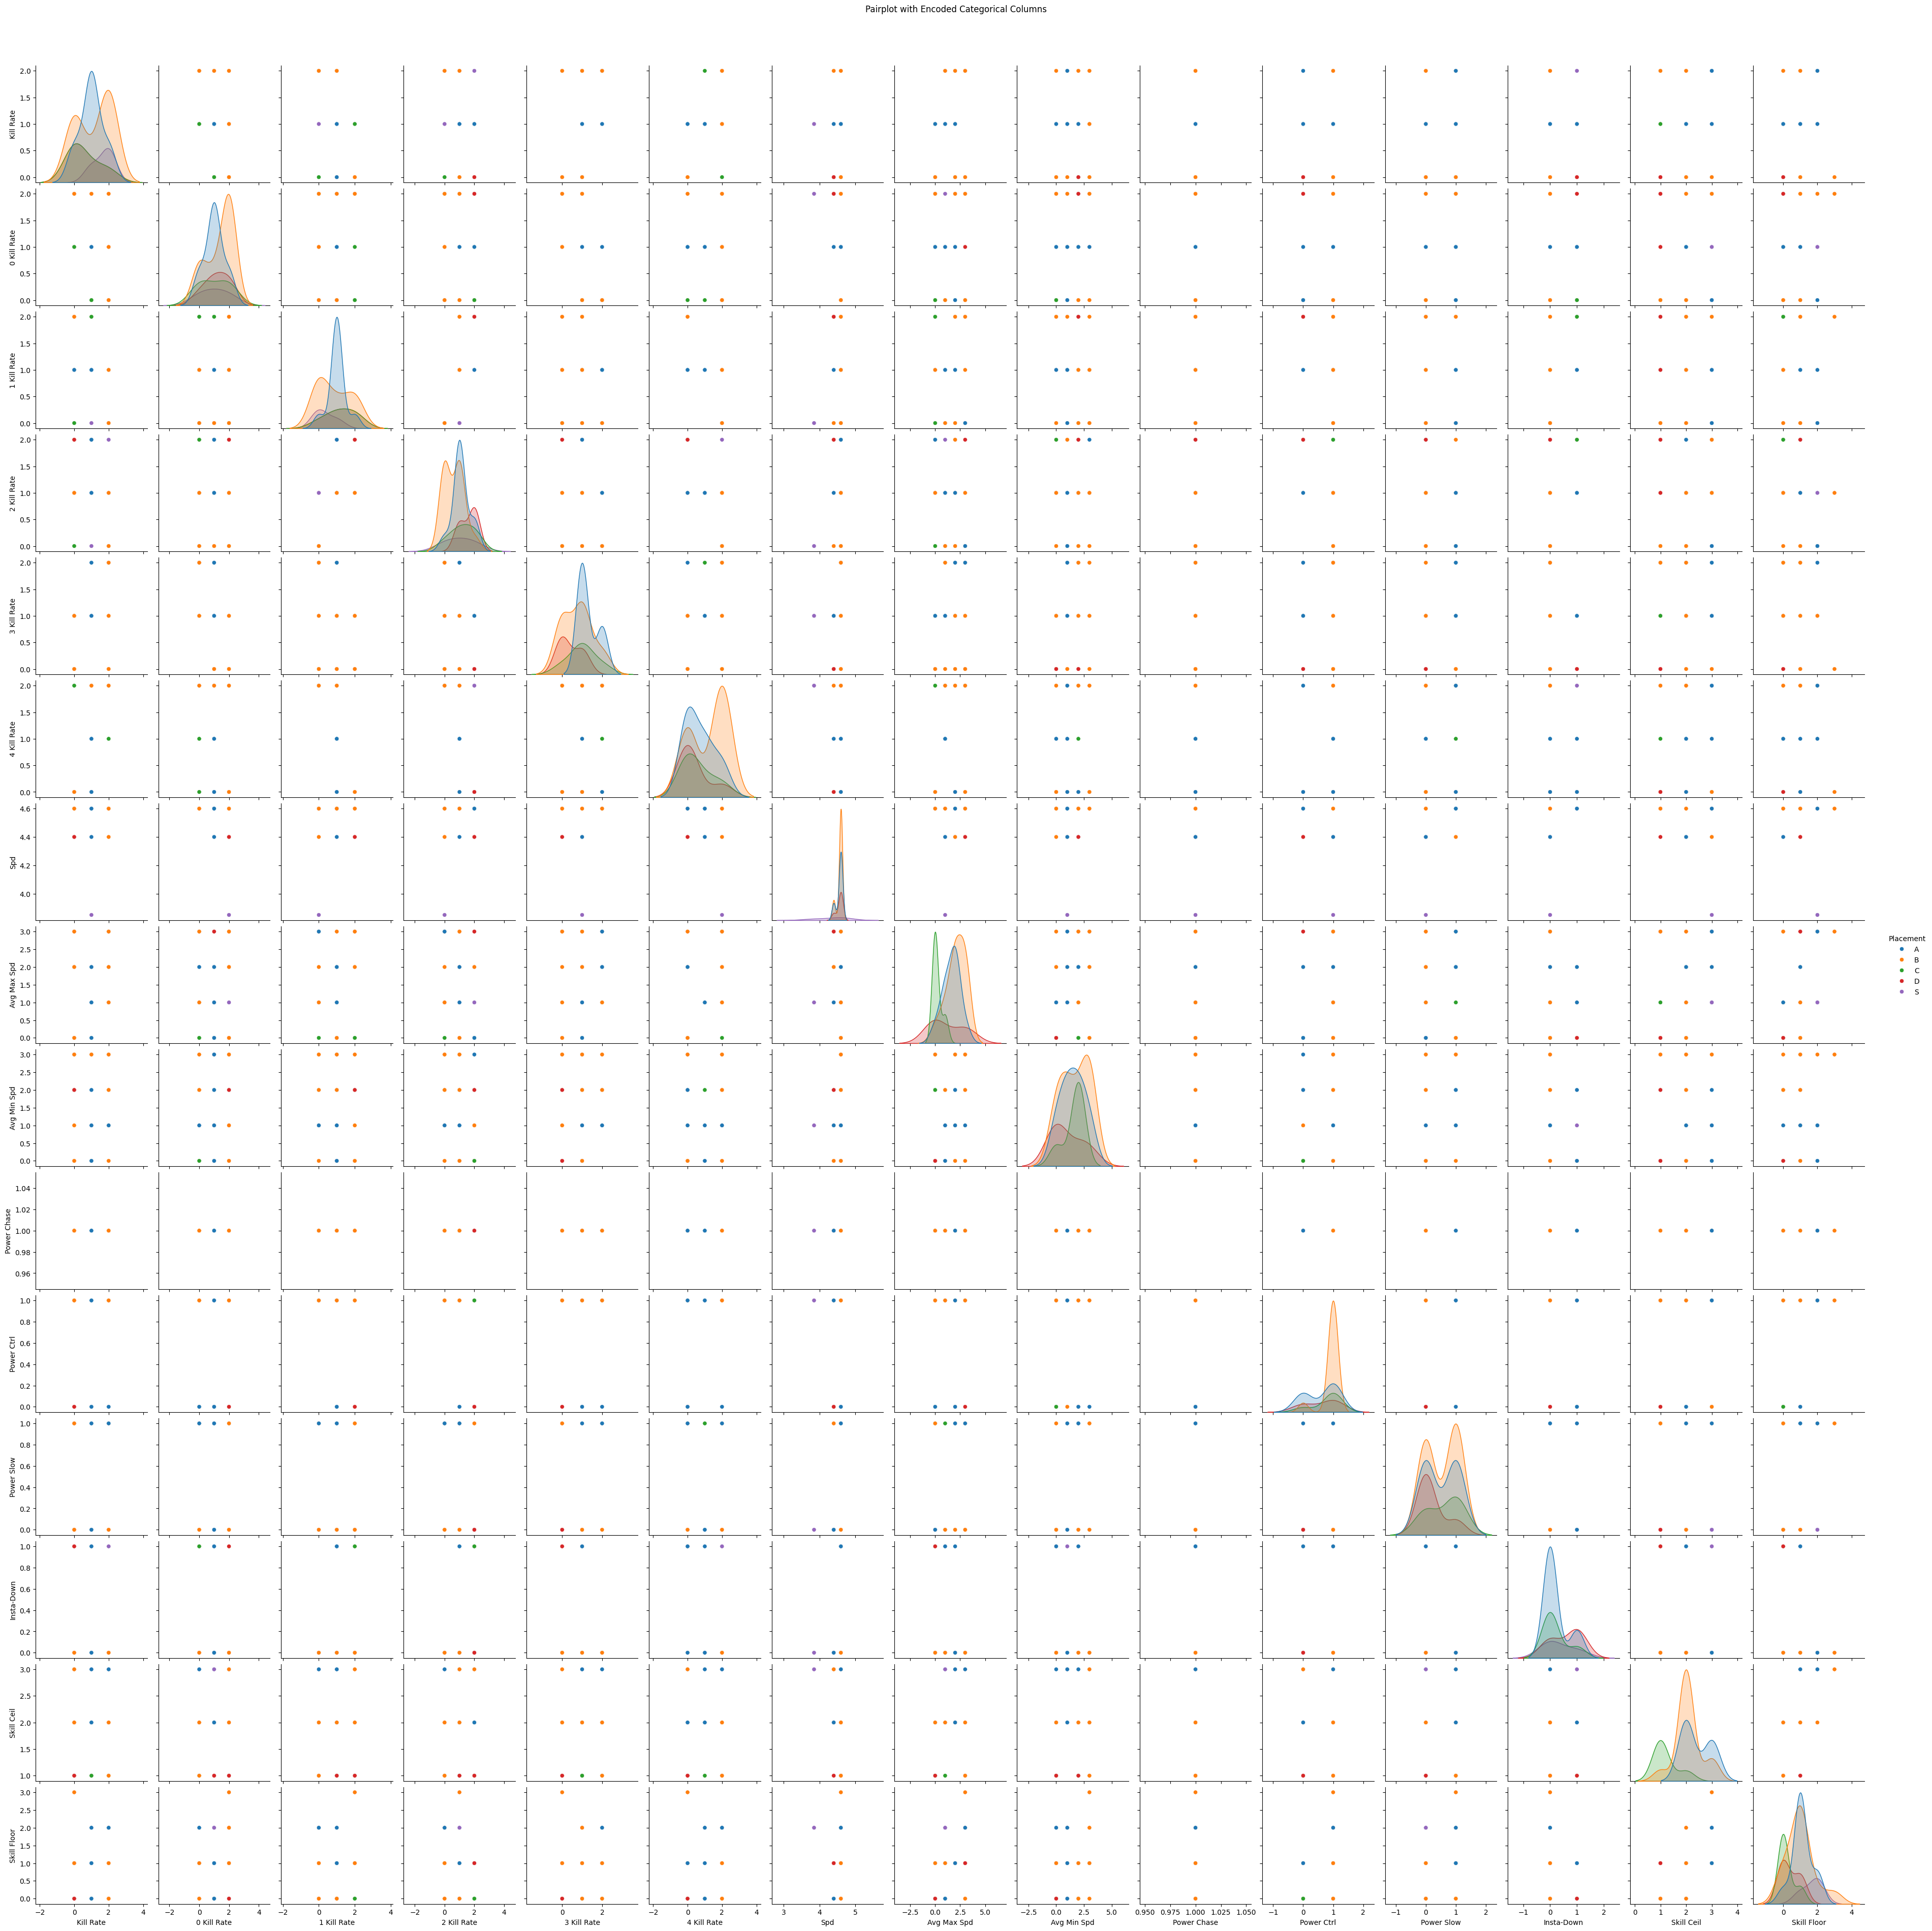

In [12]:
# Data visualization
sns.pairplot(temp_data, hue="Placement")
plt.suptitle("Pairplot with Encoded Categorical Columns", y=1.02)
plt.show()

In [13]:
# Splitting the data into training and testing sets
X = temp_data.drop(columns=[target_column])
y = temp_data[target_column].cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

## Model Evaluation

In this project, I evaluated various classification models, including Logistic Regression, Decision Trees, and Random Forests. I chose these models because:
- Logistic Regression is a strong baseline for classification tasks.
- Decision Trees offer an interpretable structure and can capture non-linear relationships.
- Random Forests are an ensemble method that can reduce overfitting and improve accuracy by combining many decision trees.

Each model was evaluated using accuracy, precision, recall, and F1 score, which are important for understanding both the overall model performance and its ability to handle different classes. For example, in situations where the data has a class imbalance, F1 score becomes more important than accuracy.


In [14]:
# Model training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=69),
    "Decision Tree with Entropy" : DecisionTreeClassifier(criterion='entropy', random_state=69),
    "Random Forest": RandomForestClassifier(random_state=69),
    "SVC": SVC(random_state=69),
    "Gradient Boosting": GradientBoostingClassifier(random_state=69)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")
    cv_scores = cross_val_score(model, X, y, cv=3)  # 3-fold cross-validation
    print(f"Cross-validated Accuracy: {np.mean(cv_scores)}")
    print(classification_report(y_test, y_pred, zero_division=0))

Logistic Regression Accuracy: 0.625
Cross-validated Accuracy: 0.5555555555555555
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.50      1.00      0.67         2
           2       0.50      1.00      0.67         1
           3       1.00      0.50      0.67         2

    accuracy                           0.62         8
   macro avg       0.75      0.71      0.62         8
weighted avg       0.81      0.62      0.60         8

Decision Tree Accuracy: 0.75
Cross-validated Accuracy: 0.47222222222222227
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         1
           3       0.67      1.00      0.80         2
           4       0.00      0.00      0.00         0

    accuracy                           0.75         8
   macro avg       0.53      

In [15]:
# Attempting to use the Entropy/Information Gain calculations to create a better dataset
top_n_features = 3
selected_features = [feature for feature, gain in sorted_features[:top_n_features]]

# Create the feature set for modeling
X = temp_data[selected_features]
y = temp_data[target_column]

In [16]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Train the model
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Accuracy with Selected Features:", accuracy_score(y_test, y_pred))
cv_scores = cross_val_score(model, X, y, cv=3)  # 3-fold cross-validation
print(f"Cross-validated Accuracy: {np.mean(cv_scores)}")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy with Selected Features: 0.375
Cross-validated Accuracy: 0.36111111111111116
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         3
           B       0.40      1.00      0.57         2
           C       0.33      1.00      0.50         1
           D       0.00      0.00      0.00         2

    accuracy                           0.38         8
   macro avg       0.18      0.50      0.27         8
weighted avg       0.14      0.38      0.21         8



In [17]:
# Try with a dataset that doesn't use categories (harder to interpret by humans)
df_v2 = pd.read_excel("KillerDatav2.xlsx")
df_v2.set_index('Name', inplace=True)
killer_data_v2 = df_v2.copy()
killer_data_v2

,Kill Rate,0 Kill Rate,1 Kill Rate,2 Kill Rate,3 Kill Rate,4 Kill Rate,Spd,Avg Max Spd,Avg Min Spd,Power Chase,Power Ctrl,Power Slow,Insta-Down,Skill Ceil,Skill Floor,Placement
Name,,,,,,,,,,,,,,,,
Trapper,53.67,21.17,18.18,14.85,16.41,29.39,4.60,4.60,0.000,1,1,0,1,2,1,1
Wraith,57.47,20.49,15.97,11.88,16.48,35.18,4.60,7.00,1.600,1,1,0,0,3,1,3
Hillbilly,57.72,17.63,17.17,14.68,17.71,32.81,4.60,9.20,1.380,1,1,0,1,4,2,5
Nurse,55.64,22.10,15.99,11.50,18.07,32.34,3.85,6.16,0.960,1,1,0,0,4,3,5
Shape,55.14,18.34,18.98,15.56,18.00,29.12,4.60,4.60,0.900,1,0,0,1,2,1,1
Hag,56.45,21.65,15.86,11.91,16.17,34.41,4.40,999.00,0.000,1,1,0,0,3,2,3
Doctor,54.10,24.37,15.80,11.37,16.01,32.45,4.60,4.60,3.100,1,1,1,0,2,2,2
Huntress,52.59,21.56,19.06,14.51,17.21,27.66,4.40,40.00,3.080,1,0,0,0,4,2,4
Cannibal,54.53,16.20,21.42,17.58,17.66,27.14,4.60,5.29,0.460,1,0,0,1,2,3,2


In [18]:
temp_data = killer_data_v2.copy()

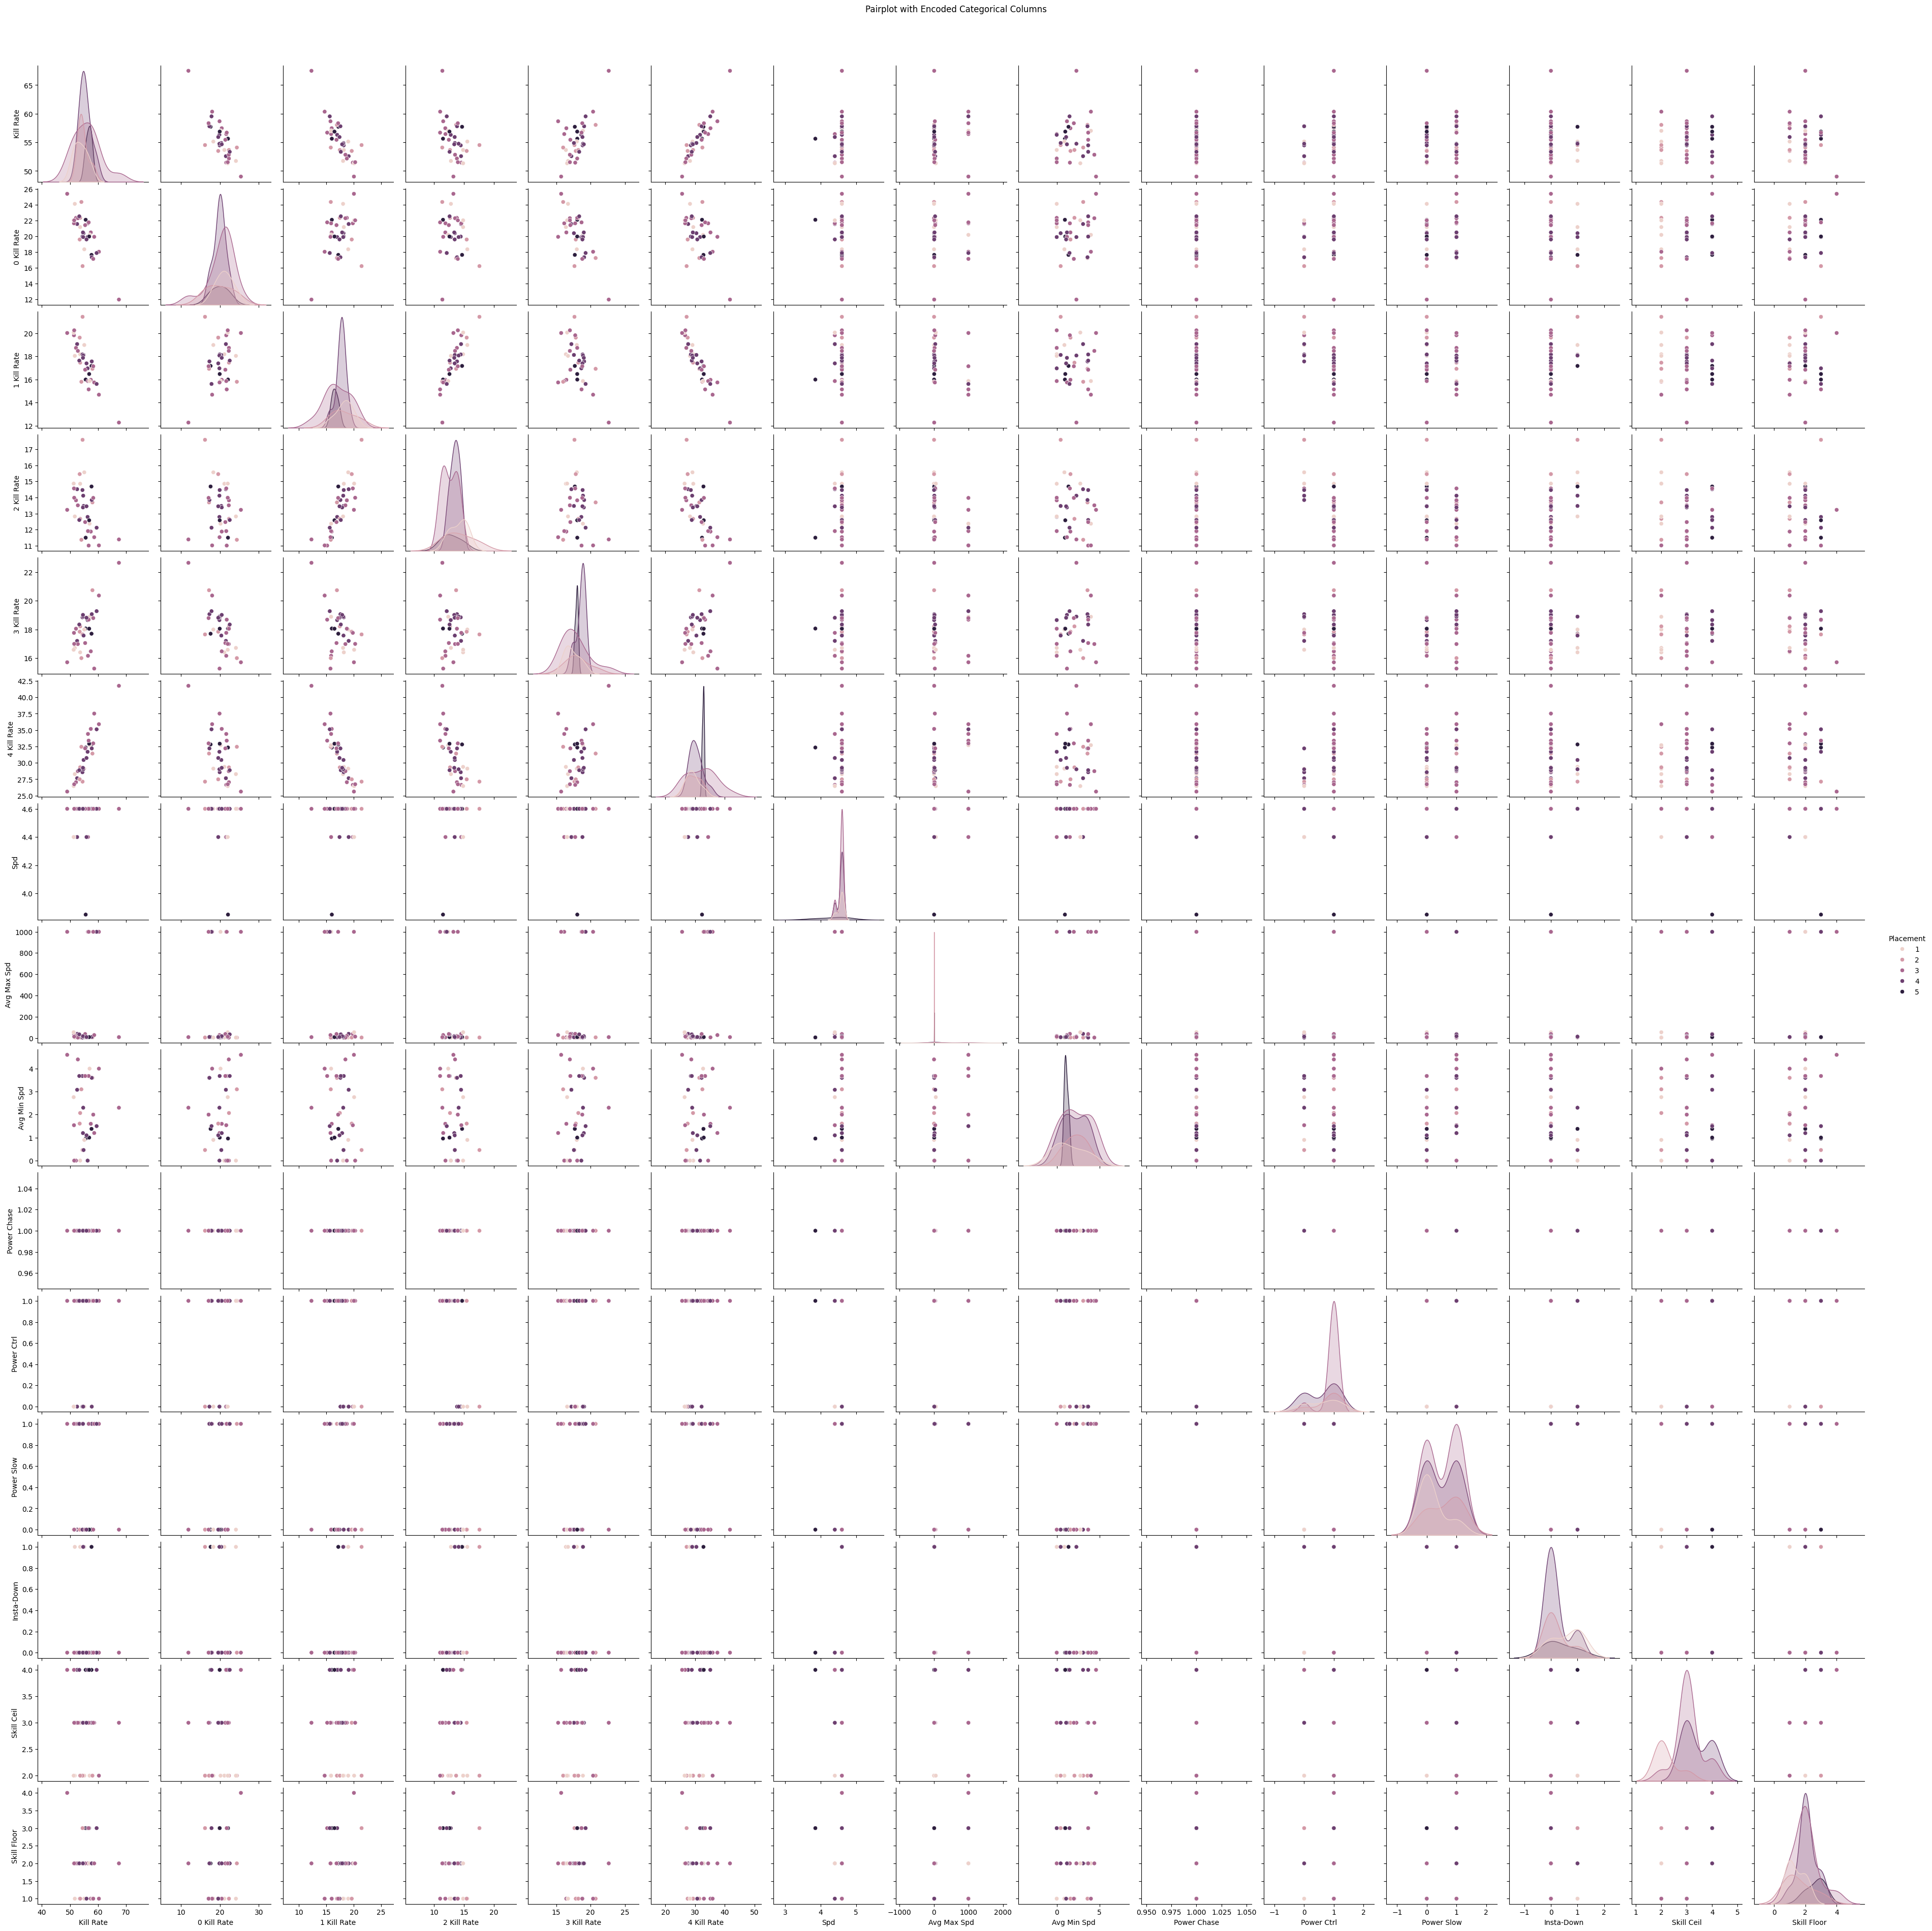

In [19]:
# Data visualization
sns.pairplot(temp_data, hue="Placement")
plt.suptitle("Pairplot with Encoded Categorical Columns", y=1.02)
plt.show()

In [20]:
# Splitting the data into training and testing sets
X = temp_data.drop(columns=[target_column])
y = temp_data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=69)
nn_model.fit(X_train_scaled, y_train)

# Evaluate the neural network model
y_pred_nn = nn_model.predict(X_test_scaled)
print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred_nn)}")

# Create a dataframe with the predicted and actual placements
comparison_df = pd.DataFrame({'Predicted': y_pred_nn, 'Actual': y_test})

# Display the first few rows of the comparison
print(comparison_df)

Neural Network Accuracy: 0.625
             Predicted  Actual
Name                          
Unknown              3       4
Artist               3       4
Shape                2       1
Plague               4       4
Dredge               3       3
Singularity          3       3
Twins                3       3
Legion               2       2


In [21]:
# Model training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=69),
    "Decision Tree with Entropy" : DecisionTreeClassifier(criterion='entropy', random_state=69),
    "Random Forest": RandomForestClassifier(random_state=69),
    "SVC": SVC(random_state=69),
    "Gradient Boosting": GradientBoostingClassifier(random_state=69)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")
    cv_scores = cross_val_score(model, X, y, cv=3)  # 3-fold cross-validation
    print(f"Cross-validated Accuracy: {np.mean(cv_scores)}")
    print(classification_report(y_test, y_pred, zero_division=0))

Logistic Regression Accuracy: 0.5
Cross-validated Accuracy: 0.5277777777777778
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       0.50      0.67      0.57         3
           4       1.00      0.33      0.50         3

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.43         8
weighted avg       0.62      0.50      0.49         8

Decision Tree Accuracy: 0.25
Cross-validated Accuracy: 0.36111111111111116
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.50      0.67      0.57         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         0

    accuracy                           0.25         8
   macro avg       0.10      0.

## **Key Findings**

Though most of the results appear to be random due to the random state, thanks to the dataset being quite small, changing the number has so far shown me that the logistic regression model is the most consistent. Even with the calculation of entropy revealing that a killer's performance is most tied with the skill ceiling it has, it doesn't seem like the current amount of data allows this information to make a significant difference in calculating their performance. However, as the game keeps adding more and more killers (The Xenomorph was the last killer that had been added to the game when this project begun), my prediciton is that this project will get more and more accurate. As it stands, a 50% accuracy is pretty good considering there are 5 possible outcomes. Randomly guessing would yield an accuracy of 20%, so I would say that this model gets the job done somewhat.

## **Future Ideas**

This model could be improved by adding an error margin. Killers often get placed within an error margin of each other by different people, since tier lists end up having subjective elements to them (I've seen people placing the current iteration of The Onryo anywhere between C and A tier, for example). Should this margin of error be added, I think the accuracy of the model would increase drastically. But then again, this is just adding some more wiggle room for the model to perform better. In my opinion, as long as it's not placing S and A tiers in the D tier and vice versa, I think the results can be discussed by tons of people without a "correct" solution being established.